In [389]:
import torch
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt

In [394]:
names = Path("../names.txt").read_text().split("\n")
num_names = len(names)
print(f"There are {num_names} names in the dataset")
print(f"First 10 are:\n{names[:10]}")

There are 32033 names in the dataset
First 10 are:
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [391]:
tokenizer = {s:i for (i,s) in enumerate(".abcdefghijklmnopqrstuvwxyz")}
print(tokenizer)
detokenizer = {i:s for (s,i) in tokenizer.items()}
print(detokenizer)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [395]:
def build_split(fro: int, to: int):
    X = []
    Y = []
    for name in names[fro:to]:
        name = "..." + name + "."
        for chars in zip(name, name[1:], name[2:], name[3:]):
            idx0 = tokenizer[chars[0]]
            idx1 = tokenizer[chars[1]]
            idx2 = tokenizer[chars[2]]
            X.append([idx0, idx1, idx2])
            Y.append(tokenizer[chars[3]])
    X = F.one_hot(torch.tensor(X), num_classes=27).float()
    Y = torch.tensor(Y)
    return X, Y

xtr, ytr = build_split(0, 20000)
print(f"xtr: {xtr.shape}")
print(f"ytr: {ytr.shape}")
xdev, ydev = build_split(20000, num_names)
print(f"xdev : {xdev.shape}")
print(f"ydev: {ydev.shape}")

xtr: torch.Size([144041, 3, 27])
ytr: torch.Size([144041])
xdev : torch.Size([84105, 3, 27])
ydev: torch.Size([84105])


In [396]:
embedding_size = 5
C = torch.randn((27, embedding_size))
W1 = torch.randn((3*embedding_size, 200)) * 0.1
b1 = torch.zeros((200))
W2 = torch.randn((200, 27)) * 0.1
b2 = torch.zeros((27))
parameters = [C, W1, b1, W2, b2]

In [397]:
num_params = 0
for param in parameters:
    param.requires_grad = True
    num_params += param.nelement()

8762


In [398]:
losses = []

In [410]:
for _ in range(2000):
    indices = torch.randint(low=0, high=xtr.shape[0], size=(30,))
    xbatch = xtr[indices]
    ybatch = ytr[indices]
    emb = xbatch @ C
    emb = emb.view((xbatch.shape[0], 3*embedding_size))
    h = emb @ W1 + b1
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ybatch)
    loss.backward()
    for param in parameters:
        param.data += -0.01 * param.grad
        param.grad = None
    losses.append(loss.item())
print(loss.item())

2.284123420715332


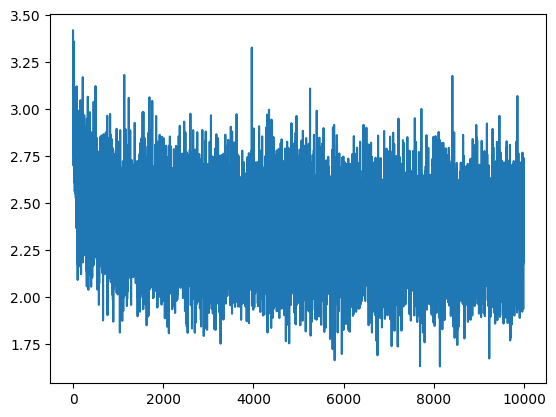

In [411]:
plt.plot(losses)

In [422]:
sampled = None
name = "..."
while sampled != ".":
    idxs = [tokenizer[chr] for chr in name[-3:]]
    context = F.one_hot(torch.tensor(idxs), num_classes=27).float()
    emb = context @ C
    emb = emb.view((1, 3*embedding_size))
    h = emb @ W1 + b1
    logits = h @ W2 + b2
    P = logits.softmax(1)
    idx = torch.multinomial(P, 1)
    sampled = detokenizer[idx.item()]
    name += sampled
print(f"{name}")

...aikletaki.
